# Bitcoin Price Analysis 

> Diamantopoulos - Pantaleon Odyssefs p3180049 <br/>
> Stogiannidis Ilias - Marios p3180178  <br />
> Department of Informatics  <br />
> Athens University of Economics and Business  <br />
> p3180178@aueb.gr

# Importing the Data

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import warnings
warnings.filterwarnings("ignore")

btc_data = pd.read_csv("BTC-USDv2.csv")
btc_data['Date'] = pd.to_datetime(btc_data['Date']) # Convert to datetime

In [116]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,7446.830,7446.830,7101.520,7143.580,7143.580,3226249984
1,2017-11-10,7173.730,7312.000,6436.870,6618.140,6618.140,5208249856
2,2017-11-11,6618.610,6873.150,6204.220,6357.600,6357.600,4908680192
3,2017-11-12,6295.450,6625.050,5519.010,5950.070,5950.070,8957349888
4,2017-11-13,5938.250,6811.190,5844.290,6559.490,6559.490,6263249920


In [117]:
btc_data.shape

(1510, 7)

> We are going to check if the prices of Close and Adjacent Close are the same in all instances.

In [118]:
(btc_data['Close'] - btc_data['Adj Close']).sum()

0.0

> Since they are the same we are going to use only one of these two columns.

> We have to check if there are null values or zeros in the dataset

In [119]:
btc_data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

> We see that there are no null values so now we are going to check for zero values

In [120]:
btc_data.query('0>=Open or 0>=High or 0>=Low or 0>=Close or 0 >=Volume')

,Date,Open,High,Low,Close,Adj Close,Volume


> Time to visualize the data

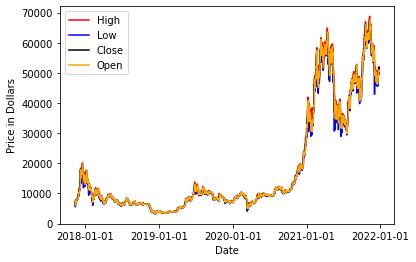

In [121]:
fig, ax = plt.subplots()
plt.plot(btc_data['Date'], btc_data['High'],color="red",label='High')
plt.plot(btc_data['Date'], btc_data['Low'],color="blue",label='Low')
plt.plot(btc_data['Date'], btc_data['Close'],color="black",label='Close')
plt.plot(btc_data['Date'], btc_data['Open'],color="orange",label='Open')


ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())

plt.legend(loc="upper left")

ax.set_xlabel('Date')
ax.set_ylabel('Price in Dollars')
plt.show()




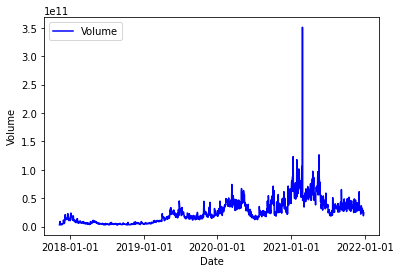

In [122]:
fig, ax = plt.subplots()
plt.plot(btc_data['Date'], btc_data['Volume'],color="blue",label='Volume')

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())

ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend(loc="upper left")

plt.show()

> We are going to use the MinMax to normalize the values.

In [123]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)) #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
X = scaler.fit_transform(btc_data[['Close', 'Adj Close','Open','High','Volume','Low']])
btc = pd.DataFrame(X, columns=[['Close', 'Adj Close','Open','High','Volume','Low']])
btc

,Close,Adj Close,Open,High,Volume,Low
0,0.061,0.061,0.065,0.064,0.001,0.062
1,0.053,0.053,0.061,0.062,0.007,0.051
2,0.049,0.049,0.053,0.055,0.006,0.048
3,0.042,0.042,0.048,0.051,0.017,0.037
4,0.052,0.052,0.042,0.054,0.010,0.042
...,...,...,...,...,...,...
1505,0.739,0.739,0.706,0.734,0.073,0.710
1506,0.740,0.740,0.740,0.741,0.062,0.749
1507,0.734,0.734,0.740,0.731,0.046,0.744
1508,0.740,0.740,0.734,0.731,0.052,0.735


We are going to find the correlation among the variables

In [124]:
corr = btc.corr()
corr

,Close,Adj Close,Open,High,Volume,Low
Close,1.000,1.000,0.998,0.999,0.608,0.999
Adj Close,1.000,1.000,0.998,0.999,0.608,0.999
Open,0.998,0.998,1.000,0.999,0.609,0.999
High,0.999,0.999,0.999,1.000,0.615,0.999
Volume,0.608,0.608,0.609,0.615,1.000,0.598
Low,0.999,0.999,0.999,0.999,0.598,1.000


> Importing the machine learning methods

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import KFold,TimeSeriesSplit
import statsmodels.api as sm
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

#https://stackoverflow.com/questions/58163026/what-is-difference-between-metrics-r2-score-and-acccuracy-score/58163220

## Linear Regression

> Conduct cross validation using the Time split method because we want to control the chronology of the data used for training

In [126]:
X = btc[['Open','High','Volume','Low']]
y = btc['Close']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.1, random_state=None)


kf = TimeSeriesSplit(n_splits=10,max_train_size =365,test_size=100) #365 because of the dates and 100 days to predict
scores =[]
losseslinear = []
i=1
#model
lr = LinearRegression()
for train_index,test_index in kf.split(X,y):
    print('{} of TimeSeriesSplit {}'.format(i,kf.n_splits))
    xtrain,xtest = X.loc[train_index],X.loc[test_index]
    ytrain,ytest = y.loc[train_index],y.loc[test_index]
    lr.fit(xtrain,ytrain)
    score =lr.score(xtest,ytest)
    loss = metrics.mean_squared_error(ytest,lr.predict(xtest)) 
    print('Score:',score)
    print('Mean squared error:',loss) #Elaxistopoiisi sinartisis lathon
    scores.append(score) 
    losseslinear.append(loss)   
    i+=1

1 of TimeSeriesSplit 10
Score: 0.99558034792197
Mean squared error: 5.736738179969626e-06
2 of TimeSeriesSplit 10
Score: 0.9868975822969007
Mean squared error: 3.724779854582332e-06
3 of TimeSeriesSplit 10
Score: 0.9835490429848796
Mean squared error: 2.401959686428323e-06
4 of TimeSeriesSplit 10
Score: 0.9924431655108706
Mean squared error: 4.008031461126057e-06
5 of TimeSeriesSplit 10
Score: 0.990228192962174
Mean squared error: 1.7802208317781753e-06
6 of TimeSeriesSplit 10
Score: 0.9977258333199508
Mean squared error: 2.718885703584076e-06
7 of TimeSeriesSplit 10
Score: 0.99401803709538
Mean squared error: 0.00018493276773589692
8 of TimeSeriesSplit 10
Score: 0.9877321070662147
Mean squared error: 0.00022801631381210683
9 of TimeSeriesSplit 10
Score: 0.9913197756868702
Mean squared error: 8.945755579789577e-05
10 of TimeSeriesSplit 10
Score: 0.9873421016745066
Mean squared error: 0.0001558032752929473


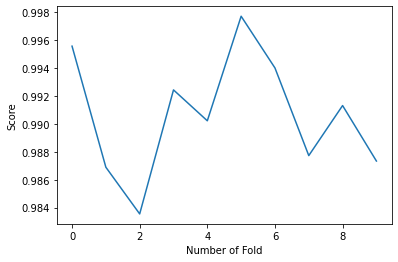

In [127]:
#Plotting Linear Regression scores
fig, ax = plt.subplots()
plt.plot(scores)
ax.set_xlabel('Number of Fold')
ax.set_ylabel('Score')
plt.show()

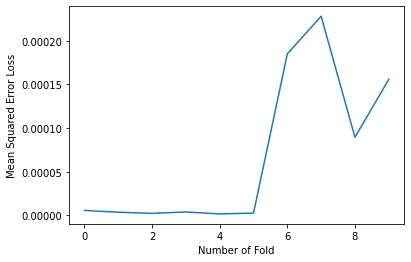

In [128]:
#Plotting Linear Regression loss
fig, ax = plt.subplots()
plt.plot(losseslinear)
ax.set_xlabel('Number of Fold')
ax.set_ylabel('Mean Squared Error Loss')
plt.show()

In [129]:
future_set = btc.shift(periods=150).tail(150)

In [130]:
prediction = lr.predict(future_set[['Open','High','Volume','Low']])

Text(0, 0.5, 'Price')

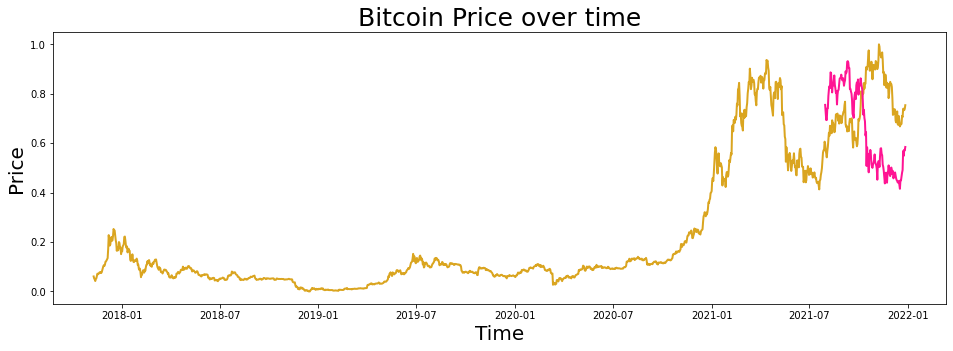

In [131]:
plt.figure(figsize = (16, 5))
plt.plot(btc_data["Date"], btc["Close"], color='goldenrod', lw=2)
plt.plot(btc_data["Date"].loc[1360:], prediction, color='deeppink', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Price", size=20)

## Logistic Regression

> Creating a new column that contains the difference of the openning with the closing price.

In [132]:
btc_data['PosNegClosing'] = btc_data['Open']- btc_data['Close']

> Then putting to all negative values the value 0 and to all posivite the value 1 in order to have a column with binary data.

In [133]:
btc_data['PosNegClosing'].mask(btc_data['PosNegClosing']>0,1,inplace=True)

In [134]:
btc_data['PosNegClosing'].mask(btc_data['PosNegClosing']<0,0,inplace=True)

In [135]:
btc_data['PosNegClosing'].max()

1.0

In [136]:
btc_data['PosNegClosing'].min()

0.0

> Put our data to X and Y dataframes

In [137]:
X = btc[['Open','High','Volume','Low','Close']]
y = btc_data['PosNegClosing']

> Conduct Logistic regression to 10 different kfolds and report their performances.

In [138]:
kf = TimeSeriesSplit(n_splits=10,max_train_size =365,test_size=10) #the bigger the test_size teh worst the performance
scores =[]
losses = []
i=1
#model
lr = LogisticRegression()
for train_index,test_index in kf.split(X,y):
    print('{} of TimeSeriesSplit {}'.format(i,kf.n_splits))
    xtrain,xtest = X.loc[train_index],X.loc[test_index]
    ytrain,ytest = y.loc[train_index],y.loc[test_index]
    lr.fit(xtrain,ytrain)
    score = lr.score(xtest,ytest)
    loss = metrics.log_loss(ytest,lr.predict(xtest))
    print('Score:',score)
    print('Log Loss:',loss) #we cant use mse https://www.analyticsvidhya.com/blog/2020/11/binary-cross-entropy-aka-log-loss-the-cost-function-used-in-logistic-regression/
    scores.append(score) 
    losses.append(loss)   
    i+=1
   

1 of TimeSeriesSplit 10
Score: 0.4
Log Loss: 20.72326583694641
2 of TimeSeriesSplit 10
Score: 0.8
Log Loss: 6.907835238725157
3 of TimeSeriesSplit 10
Score: 0.6
Log Loss: 13.815830396936352
4 of TimeSeriesSplit 10
Score: 0.6
Log Loss: 13.815830396936352
5 of TimeSeriesSplit 10
Score: 1.0
Log Loss: 9.992007221626413e-16
6 of TimeSeriesSplit 10
Score: 0.7
Log Loss: 10.361872797702265
7 of TimeSeriesSplit 10
Score: 0.7
Log Loss: 10.361872797702265
8 of TimeSeriesSplit 10
Score: 0.8
Log Loss: 6.907915198468176
9 of TimeSeriesSplit 10
Score: 0.4
Log Loss: 20.72326583694641
10 of TimeSeriesSplit 10
Score: 0.7
Log Loss: 10.361632918473205


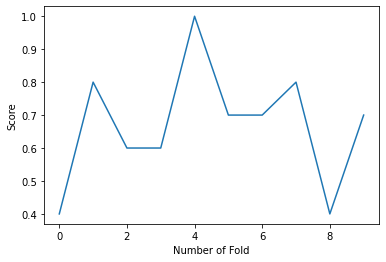

In [139]:
#Plotting Logistic Regression scores
fig, ax = plt.subplots()
plt.plot(scores)
ax.set_xlabel('Number of Fold')
ax.set_ylabel('Score')
plt.show()

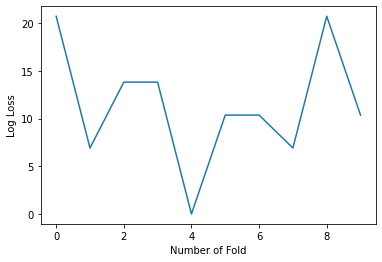

In [140]:
fig, ax = plt.subplots()
plt.plot(losses)
ax.set_xlabel('Number of Fold')
ax.set_ylabel('Log Loss')
plt.show()

## Neural Network

> Importing tensorflow

In [141]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [142]:
# number of past observations to be considered for the LSTM training and prediction
n_past = 50

# number of future datapoints to predict (if higher than 1, the model switch to Multi-Step)
n_future = 1

# activation function used for the RNN (softsign, relu, sigmoid)
activation = 'relu'

# dropout for the hidden layers
dropout = 0.2

# number of hidden layers
n_layers = 2

# number of neurons of the hidden layers
n_neurons = 50

# features to be considered for training (if only one is Close, then its Univariate, if more, then it's Multivariate)
features = ['Close', 'Volume']
#features = ['Close']

# number of inputs features (if higher than 1, )
n_features = len(features)

# patience for the early stopping (number of epochs)
patience = 25

# optimizer (adam, RMSprop)
optimizer='adam'

In [143]:
df = btc_data.set_index('Date')[features]
df = df.set_index(pd.to_datetime(df.index))
df.dropna(inplace=True)

In [144]:
training_set = df.values
print('training_set.shape:\t', training_set.shape)

training_set.shape:	 (1510, 2)


In [145]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape: ', training_set_scaled.shape)
training_set_scaled

training_set_scaled.shape:  (1510, 2)


array([[0.06073083, 0.00086937],
       [0.05256296, 0.00656405],
       [0.0485129 , 0.00570333],
       ...,
       [0.73360872, 0.04627854],
       [0.73951041, 0.05183451],
       [0.75376818, 0.06094721]])

In [146]:
# creating a data structure with 50 timesteps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1460, 50, 2), (1460, 1))

In [147]:
# reshaping (needed to fit RNN)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape

(1460, 50, 2)

> Building the model

In [148]:
# Building the RNN

# Initialising the RNN
regressor = Sequential()

# Input layer
regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
#regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 

# Hidden layers
for _ in range(n_layers):
    regressor.add(Dropout(dropout))
    regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

# Last hidden layer (changing the return_sequences)
regressor.add(Dropout(dropout))
regressor.add(LSTM(units=n_neurons, return_sequences=False, activation=activation))

# Adding the output layer
regressor.add(Dense(units=n_future))

# Compiling the RNN
regressor.compile(optimizer=optimizer, loss='mean_squared_error')

# Model summary
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 50)            10600     
                                                                 
 dropout_6 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_8 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [149]:
# Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [150]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=50
                    , epochs=10
                    , validation_split=0.1
                    , callbacks=[early_stop]
                   )

Epoch 1/10
27/27 [==============================] - 6s 89ms/step - loss: 0.0331 - val_loss: 0.0466
Epoch 2/10
27/27 [==============================] - 2s 66ms/step - loss: 0.0066 - val_loss: 0.0206
Epoch 3/10
27/27 [==============================] - 2s 62ms/step - loss: 0.0032 - val_loss: 0.0180
Epoch 4/10
27/27 [==============================] - 2s 64ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 5/10
27/27 [==============================] - 2s 66ms/step - loss: 0.0026 - val_loss: 0.0125
Epoch 6/10
27/27 [==============================] - 2s 65ms/step - loss: 0.0023 - val_loss: 0.0101
Epoch 7/10
27/27 [==============================] - 2s 66ms/step - loss: 0.0021 - val_loss: 0.0110
Epoch 8/10
27/27 [==============================] - 2s 66ms/step - loss: 0.0021 - val_loss: 0.0141
Epoch 9/10
27/27 [==============================] - 2s 64ms/step - loss: 0.0020 - val_loss: 0.0097
Epoch 10/10
27/27 [==============================] - 2s 64ms/step - loss: 0.0020 - val_loss: 0.0122


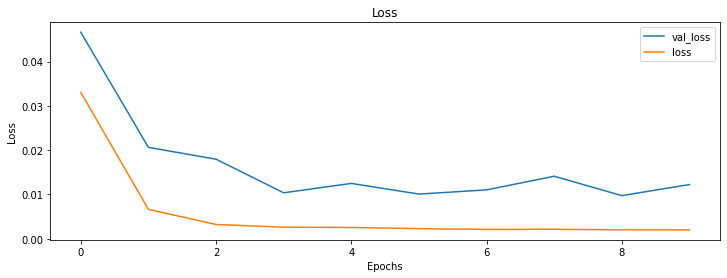

In [151]:
# Plotting Loss/MSE

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [152]:
def dummy_invscaler(y, n_features):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    y = np.array(y).reshape(-1,1)
    if n_features>1:
        dummy = np.ones((len(y), n_features-1))
        y = np.concatenate((y, dummy), axis=1)
        y = sc.inverse_transform(y)
        y = y[:,0]
    else:
        y = sc.inverse_transform(y)
    return y

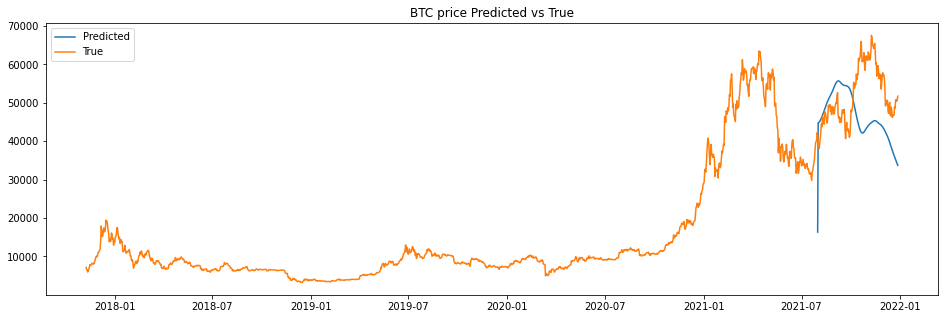

In [153]:
# Validation
# getting the predictions
y_pred = []
recursions = 150
for i in range(0,recursions):
    y_pred.append(regressor.predict(X_train[-i].reshape(1, n_past, n_features)).tolist()[0])
#
y_pred = dummy_invscaler(y_pred, n_features)
#creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                        index=df[['Close']].tail(recursions*n_future).index, 
                        columns=df[['Close']].columns)

# getting the true values
y_true_df = df[['Close']].tail(recursions*n_past)
y_true = y_true_df.tail(recursions*n_future).values




# The bellow commented code is used to create a graph of the predicted values vs the actual values
# It is used only if we predict more than one values

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

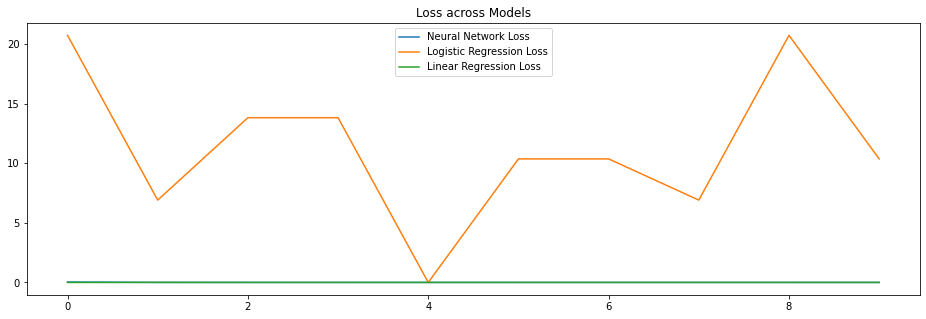

In [154]:
plt.figure(figsize=(16,5))
plt.plot(history['loss'],label='Neural Network Loss')
plt.plot(losses,label='Logistic Regression Loss')
plt.plot(losseslinear,label='Linear Regression Loss')
ax.set_xlabel('Recursion Number')
ax.set_ylabel('Loss')
plt.title('Loss across Models')
plt.legend()
plt.show()

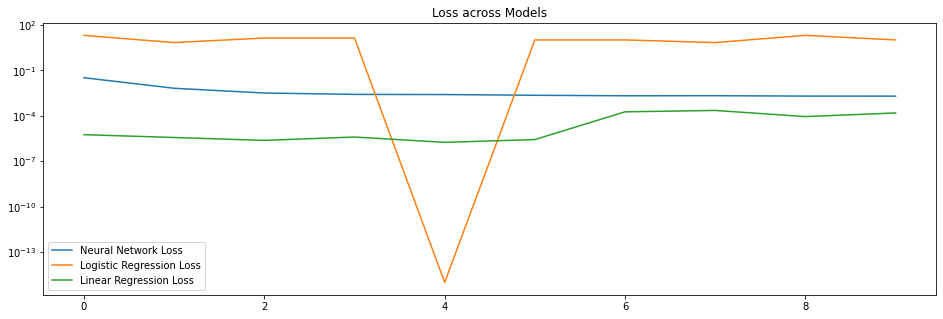

In [155]:
plt.figure(figsize=(16,5))
plt.plot(history['loss'],label='Neural Network Loss')
plt.plot(losses,label='Logistic Regression Loss')
plt.plot(losseslinear,label='Linear Regression Loss')
ax.set_xlabel('Recursion Number')
ax.set_ylabel('Loss')
plt.yscale('log')
plt.title('Loss across Models')
plt.legend()
plt.show()

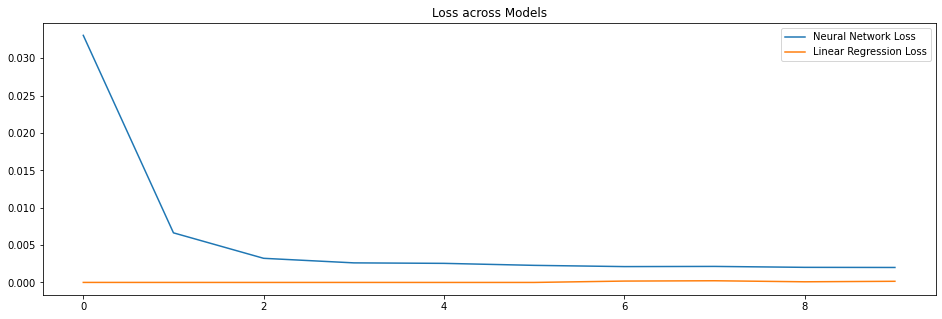

In [156]:
plt.figure(figsize=(16,5))
plt.plot(history['loss'],label='Neural Network Loss')
plt.plot(losseslinear,label='Linear Regression Loss')
ax.set_xlabel('Recursion Number')
ax.set_ylabel('Loss')
plt.title('Loss across Models')
plt.legend()
plt.show()